### Import libraries and modify notebook settings

In [ ]:
# Import libraries
import os
import sys
import h5py
import numpy as np
import pandas as pd
import librosa
#import librosa.display
import matplotlib.pyplot as plt

# Modify notebook settings
%matplotlib inline

In [2]:
from IPython.display import Audio

### Create paths to data folders and files

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the raw metadata file
# "UrbanSound8K.csv"
metadata_file = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "metadata",
                             "UrbanSound8K.csv")

# Save path to the raw audio files
raw_audio_path = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "audio")

# Save the path to the folder that will contain 
# the interim data sets for modeling:
# /data/interim
interim_data_dir = os.path.join(proj_root,
                                "data",
                                "interim")

# Save path to the folder for the
# spectrogram arrays that we will generate
spectrogram_arrays_path = os.path.join(interim_data_dir,
                                       "spectrogram_arrays")


In [4]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Inspect the metadata

In [5]:
df_metadata = pd.read_csv(metadata_file)

In [6]:
df_metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
total_obs = len(df_metadata)
total_obs

8732

#### Is the proportion of observations for each class is roughly similar across the ten folds?
Groupby class and fold

In [8]:
df_metadata.groupby(['class','fold'])['fold'].count().unstack()

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100
car_horn,36,42,43,59,98,28,28,30,32,33
children_playing,100,100,100,100,100,100,100,100,100,100
dog_bark,100,100,100,100,100,100,100,100,100,100
drilling,100,100,100,100,100,100,100,100,100,100
engine_idling,96,100,107,107,107,107,106,88,89,93
gun_shot,35,35,36,38,40,46,51,30,31,32
jackhammer,120,120,120,120,120,68,76,78,82,96
siren,86,91,119,166,71,74,77,80,82,83


The proportion of observations for each class is roughly similar across the ten folds.

#### Do all of the audio clips have the same length?

We want to only use clips that have the same temporal length.  Otherwise, the shape (dimensions) of features that we feed the CNN would not be uniform.  In other words, once we create spectrograms from each `.wav` file, we want all of the spectrograms to have the same width.

In [9]:
(df_metadata.end - df_metadata.start).value_counts().head(25)

4.000000    6573
4.000000     155
4.000000     128
4.000000      92
4.000000      86
4.000000      82
4.000000      57
4.000000      54
4.000000      31
4.000000      20
4.000000      13
4.000000      10
4.000000       8
4.000000       7
4.000000       5
4.000000       5
4.000000       5
2.399496       2
0.530784       2
0.598078       2
1.832272       2
0.691628       2
1.149388       2
0.611206       2
1.358367       2
dtype: int64

The majority of the audio clips are approximately 4 seconds long.  Therefore, we will only use audio clips are approximately 4 seconds long and exclude the other audio clips.

Let us filter for the observations that had audio clips that are approximately 4 seconds long.

In [10]:
# Filter for the observations that had audio clips 
# that are approximately 4 seconds long.
bool_mask = np.isclose((df_metadata.end - df_metadata.start), 
                       4,
                       rtol=1e-05)

df_metadata_4s = df_metadata[bool_mask]

How much data are we left with?

In [11]:
len(df_metadata_4s)

7333

In [12]:
len(df_metadata_4s) / total_obs

0.8397846999541915

We still have 7333 observations, or about 84% of the original data.

#### Are the folds still even? Does each class have enough data?

After filtering for the observations that had audio clips that are approximately 4 seconds long, does each class still have enough data?
Are there roughly the same number of observations for each class across all folds?

In [13]:
df_metadata_4s.groupby(['class','fold'])['fold'].count().unstack()

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,99.0,99.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
car_horn,14.0,16.0,22.0,36.0,70.0,10.0,5.0,9.0,5.0,16.0
children_playing,97.0,98.0,98.0,97.0,97.0,98.0,98.0,99.0,96.0,98.0
dog_bark,67.0,64.0,72.0,64.0,68.0,63.0,77.0,66.0,66.0,68.0
drilling,82.0,67.0,88.0,90.0,64.0,83.0,97.0,72.0,78.0,84.0
engine_idling,94.0,98.0,100.0,104.0,101.0,107.0,102.0,77.0,89.0,89.0
gun_shot,NaN,1.0,NaN,4.0,NaN,NaN,11.0,NaN,NaN,NaN
jackhammer,104.0,101.0,104.0,58.0,106.0,67.0,54.0,59.0,77.0,73.0
siren,86.0,91.0,118.0,158.0,64.0,73.0,72.0,79.0,79.0,77.0


It appears that many of the audio clips that were less than 4 seconds long were recordings of gun shots.  There are now too few observations of the `gun_shot` class in our filtered data set to create a predictive model for that class.  We will remove the few remaining observations of the `gun_shot` class.

In a similar vein, there may be too few observations of the `car_horn` class to create a predictive model for that class.  Therefore, we will remove observations of the `car_horn` class.

In [14]:
# Create boolean filters
not_gun_shot = (df_metadata_4s['class'] != 'gun_shot')
not_car_horn = (df_metadata_4s['class'] != 'car_horn')

# Filter the df
df_metadata_filtered = df_metadata_4s[not_gun_shot & not_car_horn]

# reset_index
df_metadata_filtered.reset_index(drop=False, inplace=True)

In [15]:
len(df_metadata_filtered)

7114

In [16]:
len(df_metadata_filtered) / total_obs

0.8147045350435181

We still have 7114 observations, or about 81% of the original data.

In [17]:
df_metadata_filtered.groupby(['class','fold'])['fold'].count().unstack()

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,99,99,100,100,99,100,100,100,100,100
children_playing,97,98,98,97,97,98,98,99,96,98
dog_bark,67,64,72,64,68,63,77,66,66,68
drilling,82,67,88,90,64,83,97,72,78,84
engine_idling,94,98,100,104,101,107,102,77,89,89
jackhammer,104,101,104,58,106,67,54,59,77,73
siren,86,91,118,158,64,73,72,79,79,77
street_music,100,100,100,100,100,100,100,100,100,100


###  Are all slice_file_name obs unique?

In [18]:
print(df_metadata.slice_file_name.value_counts().max(),
      ';',
      df_metadata_filtered.slice_file_name.value_counts().max())

1 ; 1


Yes, all observations of slice_file_name are unique.

### One-hot encode the target variable: classID

    #pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)[source]

    df_interim = pd.get_dummies(df_metadata_filtered, 
                                prefix='y', 
                                prefix_sep='_',
                                columns=['classID'], 
                                drop_first=False)

    df_interim.head()

### Drop unneeded columns and rearrange columns

In [19]:
df_interim = df_metadata_filtered[['classID',
                                   'slice_file_name',
                                   'fold']]
    
df_interim.head()

,classID,slice_file_name,fold
0,2,100263-2-0-117.wav,5
1,2,100263-2-0-121.wav,5
2,2,100263-2-0-126.wav,5
3,2,100263-2-0-137.wav,5
4,2,100263-2-0-143.wav,5


### Sort and reindex the DataFrame

In [20]:
df_interim = df_interim.sort_values(['fold', 'slice_file_name'])

In [21]:
df_interim.reset_index(drop=True, inplace=True)

In [22]:
df_interim.head()

,classID,slice_file_name,fold
0,3,101415-3-0-2.wav,1
1,3,101415-3-0-3.wav,1
2,3,101415-3-0-8.wav,1
3,3,102842-3-0-1.wav,1
4,3,102842-3-1-0.wav,1


### Create a key table for matching 'classID' with 'class'

In [23]:
df_temp = df_metadata.groupby(['class','classID'])['classID'].count().unstack()
df_temp

classID,0,1,2,3,4,5,6,7,8,9
class,,,,,,,,,,
air_conditioner,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_horn,NaN,429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
children_playing,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dog_bark,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN
drilling,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN
engine_idling,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN
gun_shot,NaN,NaN,NaN,NaN,NaN,NaN,374.0,NaN,NaN,NaN
jackhammer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN
siren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,929.0,NaN


In [24]:
classID_list =list(df_temp.columns)
class_list =  list(df_temp.index)

df_class_key = pd.DataFrame({'class': class_list, 
                             'classID': classID_list})
df_class_key

,class,classID
0,air_conditioner,0
1,car_horn,1
2,children_playing,2
3,dog_bark,3
4,drilling,4
5,engine_idling,5
6,gun_shot,6
7,jackhammer,7
8,siren,8
9,street_music,9


## Define train and test set data.

Define folds 1 through 8 to be train data.  Define folds 9 and 10 to be test data.  

In [25]:
df_interim['test_data'] = df_interim.fold >= 9

In [26]:
df_interim.head()

,classID,slice_file_name,fold,test_data
0,3,101415-3-0-2.wav,1,False
1,3,101415-3-0-3.wav,1,False
2,3,101415-3-0-8.wav,1,False
3,3,102842-3-0-1.wav,1,False
4,3,102842-3-1-0.wav,1,False


In [27]:
np.sum(df_interim.test_data == True)

1374

In [28]:
np.sum(df_interim.test_data == False)

5740

In [29]:
np.sum(df_interim.test_data == False) / len(df_interim)

0.80685971324149564

In [30]:
df_test = df_interim[df_interim.test_data == True]
df_test.head()

,classID,slice_file_name,fold,test_data
5740,0,101729-0-0-1.wav,9,True
5741,0,101729-0-0-11.wav,9,True
5742,0,101729-0-0-12.wav,9,True
5743,0,101729-0-0-13.wav,9,True
5744,0,101729-0-0-14.wav,9,True


In [31]:
df_train = df_interim[df_interim.test_data == False]
df_train.head()

,classID,slice_file_name,fold,test_data
0,3,101415-3-0-2.wav,1,False
1,3,101415-3-0-3.wav,1,False
2,3,101415-3-0-8.wav,1,False
3,3,102842-3-0-1.wav,1,False
4,3,102842-3-1-0.wav,1,False


## Save `df_interim` and `df_class_key` to new csv files.

In [32]:
new_file_name = 'metadata_interim.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_interim.to_csv(new_file_path)

In [33]:
new_file_name = 'classID_key.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)

df_class_key.to_csv(new_file_path)

In [34]:
new_file_name = 'metadata_train.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_train.to_csv(new_file_path)

In [35]:
new_file_name = 'metadata_test.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_test.to_csv(new_file_path)

## Process audio files

In [36]:
df_train.head()

,classID,slice_file_name,fold,test_data
0,3,101415-3-0-2.wav,1,False
1,3,101415-3-0-3.wav,1,False
2,3,101415-3-0-8.wav,1,False
3,3,102842-3-0-1.wav,1,False
4,3,102842-3-1-0.wav,1,False


In [37]:
global_sr = 22050
global_n_mels = 96

#pitch_shift_list = [None, -4, -3, -2, -1, 1, 2, 3, 4]
pitch_shift_list = [None, -4, -2, 2, 4]
time_stretch_list = [None, 0.8]

In [38]:
for index, row in df_train.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    
    if index >= 1:
        break
        

15
86,100


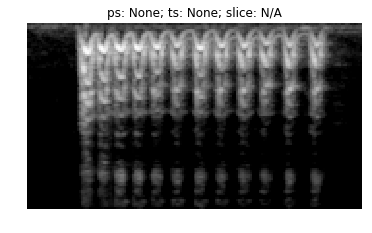

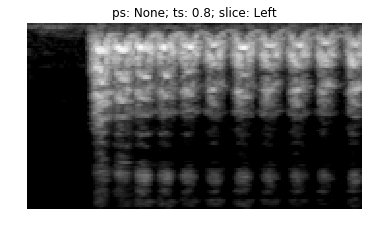

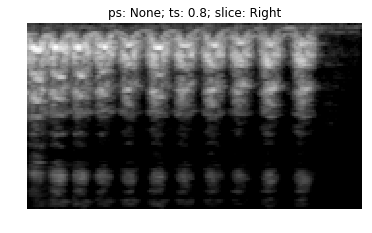

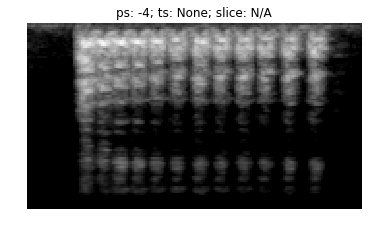

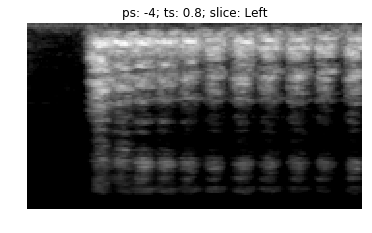

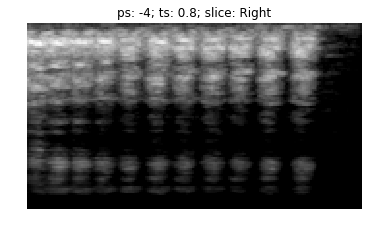

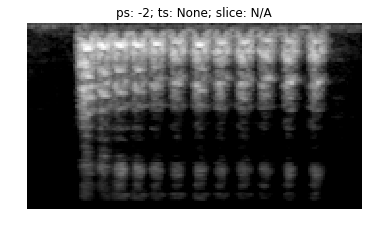

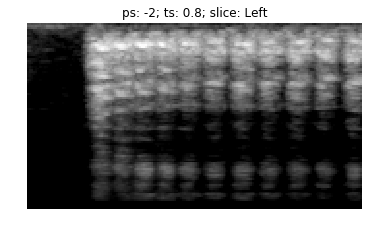

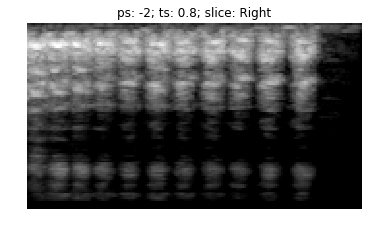

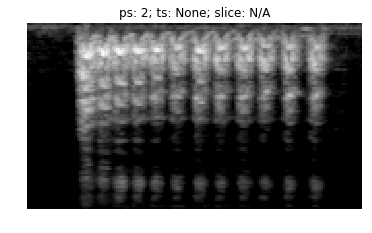

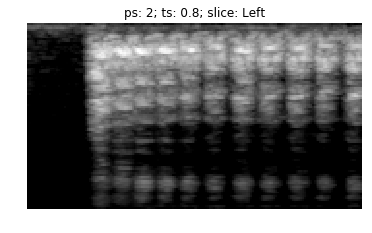

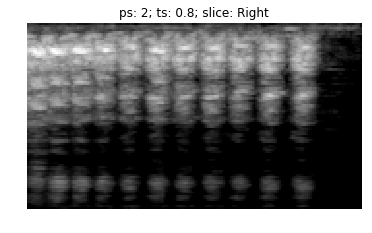

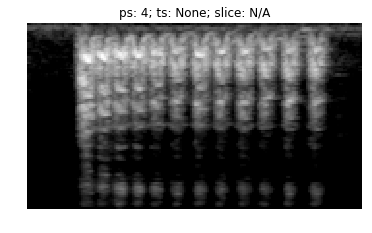

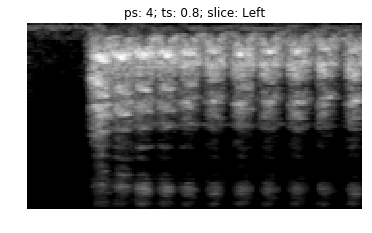

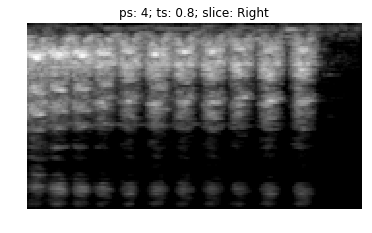

In [39]:
count = 0

for ps in pitch_shift_list:
    for ts in time_stretch_list:

        aud_array_aug = aud_array

        
        # Pitch shift
        if ps is not None:
            aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

        # Time stretch
        if ts is not None:
            aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

        # Create spectrogram array
        spec_array = librosa.logamplitude(\
                        librosa.feature.melspectrogram(aud_array_aug, 
                                                       sr=global_sr,
                                                       n_mels=global_n_mels),
                                          ref_power=1.0)[np.newaxis,:,:,
                                                         np.newaxis]
        
        # Time stretch
        if ts is not None:
            
            spec_array_full = spec_array
            
            # Left slice            
            spec_array = spec_array_full[:,:,:173,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
            plt.title(title)            
            plt.axis('off')

            count += 1
            
            # Right slice            
            spec_array = spec_array_full[:,:,-173:,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Right'
            plt.title(title)
            plt.axis('off')

            count += 1
            
        else:
            
            spec_array = spec_array[:,:,:173,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: N/A'
            plt.title(title)
            plt.axis('off')

            count += 1
            
print(count)
print('{:,}'.format(count * len(df_train)))

In [40]:
train_len = count * len(df_train)
train_len

86100

In [41]:
test_len = len(df_test)
test_len

1374

### Create an `.hdf5` file to store spectrogram data we will generate from the `.wav` files.

Determine the size of the dataset

In [42]:
# Test set
dset_shape_X_test = (test_len, 96, 173,  1)
dset_shape_y_test = (test_len, 1)
print('dset_shape_X_test:\t', dset_shape_X_test)
print('dset_shape_y_test:\t', dset_shape_y_test)

# Train set
dset_shape_X_train = (train_len, 96, 173,  1)
dset_shape_y_train = (train_len, 1)
print('dset_shape_X_train:\t', dset_shape_X_train)
print('dset_shape_y_train:\t', dset_shape_y_train)

dset_shape_X_test:	 (1374, 96, 173, 1)
dset_shape_y_test:	 (1374, 1)
dset_shape_X_train:	 (86100, 96, 173, 1)
dset_shape_y_train:	 (86100, 1)


In [43]:
# Full path for test_hdf5_path
test_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_test.hdf5")

with h5py.File(test_hdf5_path, 'w') as f:
    f.create_dataset("spectrogram_arrays_X_test", 
                     shape=dset_shape_X_test, 
                     dtype='float32',
                     data=np.zeros(dset_shape_X_test, dtype='float32'),
                     chunks=(1, 96, 173, 1),
                     compression="gzip")
    
    f.create_dataset("spectrogram_arrays_y_test", 
                     shape=dset_shape_y_test, 
                     dtype='int8',
                     data=np.zeros(dset_shape_y_test, dtype='int8'),
                     compression="gzip")
    
# Full path for train_hdf5_path
train_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_train.hdf5")

with h5py.File(train_hdf5_path, 'w') as f:
    f.create_dataset("spectrogram_arrays_X_train", 
                     shape=dset_shape_X_train, 
                     dtype='float32',
                     data=np.zeros(dset_shape_X_train, dtype='float32'),
                     chunks=(1, 96, 173, 1),
                     compression="gzip")
    
    f.create_dataset("spectrogram_arrays_y_train", 
                     shape=dset_shape_y_train, 
                     dtype='int8',
                     data=np.zeros(dset_shape_y_train, dtype='int8'),
                     compression="gzip")        

### Generate data for spectrogram_arrays_X_test & spectrogram_arrays_y_test

In [44]:
count = 0

for index, row in df_test.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    # Create spectrogram array
    spec_array = librosa.logamplitude(\
                    librosa.feature.melspectrogram(aud_array, 
                                                   sr=global_sr,
                                                   n_mels=global_n_mels),
                                      ref_power=1.0)[np.newaxis,:,:,
                                                     np.newaxis]
    
    # Convert spectrogram array from dtype float64 to float32
    spec_array = spec_array.astype('float32')

    # Write to the hdf5 file
    with h5py.File(test_hdf5_path, "r+") as f:
        # X_train
        dset = f['spectrogram_arrays_X_test']    
        # limit tensor height to 173 (there were a few tensors with 174)
        dset[count,:,:,:] = spec_array[:,:,:173,:]
        # y_train
        dset = f['spectrogram_arrays_y_test']    
        dset[count,:] = row['classID']

        count += 1        

### Generate data for spectrogram_arrays_X_train & spectrogram_arrays_y_train

In [45]:
count = 0

for index, row in df_train.iterrows():
    
    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    for ps in pitch_shift_list:
        for ts in time_stretch_list:

            aud_array_aug = aud_array

            # Pitch shift
            if ps is not None:
                aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

            # Time stretch
            if ts is not None:
                aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

            # Create spectrogram array
            spec_array = librosa.logamplitude(\
                            librosa.feature.melspectrogram(aud_array_aug, 
                                                           sr=global_sr,
                                                           n_mels=global_n_mels),
                                              ref_power=1.0)[np.newaxis,:,:,
                                                             np.newaxis]

            # Time stretch
            if ts is not None:

                spec_array_full = spec_array

                # Left slice            
                spec_array = spec_array_full[:,:,:173,:]
    
                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1
    
                # Right slice            
                spec_array = spec_array_full[:,:,-173:,:]

                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1
    
            else:

                spec_array = spec_array[:,:,:173,:]

                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1


# Inspect `HDF5` data

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.dtype)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.dtype)    

with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.dtype)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.dtype)        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.shape)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.shape)
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.shape)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.shape)
        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.ndim)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.ndim)
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.ndim)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.ndim)
        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.len())
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.len())
        

In [1]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.maxshape)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.len())
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.len())
        

NameError: name 'h5py' is not defined